In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
#tf.config.set_visible_devices([], 'GPU')
print(tf.__version__)
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpu_devices))
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, LeakyReLU, ELU, ReLU, GaussianNoise, Softmax
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import regularizers
#from keras.layers.normalization import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.losses import MeanSquaredError, CategoricalCrossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras.metrics import Precision
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score

2.2.0
Num GPUs Available:  0


2023-01-15 14:40:43.432557: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-01-15 14:40:43.470360: E tensorflow/stream_executor/cuda/cuda_driver.cc:313] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-01-15 14:40:43.470372: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (dominykas-MS-7B00): /proc/driver/nvidia/version does not exist


In [3]:
legend_names = ["$QCD$", "$W + Jets$", "$WW$", "$WZ$", "$ZZ$", "$\\bar{t}W$", "$tW$", "$t\\bar{t}$", 
                "$Drell Yan \\rightarrow \\tau\\tau$", "$Drell Yan \\rightarrow \\mu\\mu$"]
legend_names = legend_names[1:]
Process_limits = [None, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Min_Max = pd.read_csv("/home/dominykas/dy_mas_do/MuMu/MC_data_min_max.csv")
Min_Max.T

0             1
Process     0.000000e+00  9.000000e+00
Weight     -1.213690e+01  2.025310e+03
Phot_count  0.000000e+00  9.000000e+00
InvM        0.000000e+00  1.145740e+04
MET_pT     -2.147480e+09  1.610610e+09
MET_phi    -2.147480e+09  2.147480e+09
pT_l1       0.000000e+00  3.055180e+04
eta_l1     -2.400000e+00  2.400000e+00
phi_l1     -3.141590e+00  3.141590e+00
E_l1        0.000000e+00  1.512200e+05
pT_l2       0.000000e+00  1.175280e+04
eta_l2     -2.400000e+00  2.400000e+00
phi_l2     -3.141590e+00  3.141590e+00
E_l2        0.000000e+00  2.716170e+04
pT_p0       0.000000e+00  4.356050e+03
eta_p0     -2.988760e+00  2.993970e+00
phi_p0     -3.141590e+00  3.141590e+00
E_p0        0.000000e+00  5.698540e+03
pT_p1       0.000000e+00  1.044100e+03
eta_p1     -2.974560e+00  2.978560e+00
phi_p1     -3.141570e+00  3.141590e+00
E_p1        0.000000e+00  2.737400e+03
pT_p2       0.000000e+00  2.679340e+02
eta_p2     -2.963530e+00  2.973900e+00
phi_p2     -3.141590e+00  3.141420e+00
E_p2        0.000000e+00  8.317200e+02
pT_p3       0.000000e+00  1.384830e+02
eta_p3     -2.949690e+00  2.945450e+00
phi_p3     -3.141410e+00  3.141540e+00
E_p3        0.000000e+00  6.037510e+02
pT_p4       0.000000e+00  7.799420e+01
eta_p4     -2.918440e+00  2.940650e+00
phi_p4     -3.133370e+00  3.140410e+00
E_p4        0.000000e+00  3.058210e+02
pT_p5       0.000000e+00  3.969430e+01
eta_p5     -2.895730e+00  2.944330e+00
phi_p5     -3.140780e+00  3.120670e+00
E_p5        0.000000e+00  2.067360e+02
pT_p6       0.000000e+00  3.520470e+01
eta_p6     -2.725260e+00  2.870970e+00
phi_p6     -3.123810e+00  3.047270e+00
E_p6        0.000000e+00  1.934630e+02
pT_p7       0.000000e+00  3.147250e+01
eta_p7     -1.471850e+00  2.325520e+00
phi_p7     -3.013800e+00  2.853230e+00
E_p7        0.000000e+00  1.202850e+02
pT_p8       0.000000e+00  1.442750e+01
eta_p8     -6.002650e-01  2.496960e+00
phi_p8     -9.824030e-01  3.983410e-01
E_p8        0.000000e+00  7.372840e+01

In [4]:
def data_read_rescale(data_loc_name, scale=None, limit=None):
    #print("Reading " + data_loc_name)
    DF_init = pd.read_csv(data_loc_name, dtype=np.float32)
    DF = pd.DataFrame(columns=DF_init.columns)
    if limit is None:
        DF = DF_init
        #print(DF.shape, DF_init.shape)
    else:
        new_process_num = 0
        for i in range(len(limit)):
            if limit[i] is None:
                continue
            if limit[i] == 0:
                DF = pd.concat([DF, DF_init.loc[DF_init['Process'] == i]], ignore_index=True)
            else:
                DF = pd.concat([DF, DF_init.loc[DF_init['Process'] == i].reset_index(drop=True).iloc[:limit[i]]], ignore_index=True)
            DF['Process'].loc[DF['Process'] == i] = new_process_num
            #print(DF['Process'].unique(), i, new_process_num)
            new_process_num += 1
    if scale is None:
        return DF
    else:
        DF[DF.columns[2:]] = ((DF - scale[0]) / (scale[1] - scale[0]))[DF.columns[2:]]
        return DF

def Y_rebuild(Y, classes):
    Y_mod = pd.DataFrame()
    for i in range(len(classes)):
        Y_mod[classes[i]] = (Y == i)*1
    return Y_mod
    

In [5]:
DF = data_read_rescale("/home/dominykas/dy_mas_do/MuMu/MC_data_0.csv", scale=Min_Max.T, limit=Process_limits)
X = DF[DF.columns[2:]]
Y_s = DF['Process']

In [6]:
bins = np.linspace(-0.5, len(legend_names) - 0.5, len(legend_names)+1)
plt.figure(figsize=[10, 6])
counts, edges, bars = plt.hist(Y_s, bins=bins)
plt.xticks(range(len(legend_names)), legend_names)
#print(counts)
plt.bar_label(bars)

[Text(0, 0, '76'),
 Text(0, 0, '1922'),
 Text(0, 0, '2576'),
 Text(0, 0, '1632'),
 Text(0, 0, '2820'),
 Text(0, 0, '2803'),
 Text(0, 0, '70533'),
 Text(0, 0, '1716'),
 Text(0, 0, '915921')]

In [7]:
Y = Y_rebuild(Y_s, legend_names)

X.shape

(999999, 48)

In [8]:
data_loc = "/home/dominykas/dy_mas_do/MuMu/"
data_name = "MC_data_"
bins = np.linspace(-0.5, len(legend_names) - 0.5, len(legend_names)+1)
w_counts_full = np.zeros(bins.shape[0] - 1)
counts_full = np.zeros(bins.shape[0] - 1)
for j in range(17):
    print("Reading " + data_name + str(j))
    DF_whist = data_read_rescale(data_loc + data_name + str(j) + ".csv", limit=Process_limits)
    w_counts, edges = np.histogram(DF_whist['Process'], weights=DF_whist['Weight'], bins=bins)
    counts, edges = np.histogram(DF_whist['Process'], bins=bins)
    w_counts_full = w_counts_full + w_counts
    counts_full = counts_full + counts
    #print(w_counts_full)
width = 0.35
plt.figure(figsize=[10, 6])
f_bars_1 = plt.bar(bins[:-1] - width/2 + 0.5, counts_full, width
                   #, log=True
                  )
f_bars_2 = plt.bar(bins[:-1] + width/2 + 0.5, w_counts_full, width
                   #, log=True
                  )
plt.xticks(range(len(legend_names)), legend_names)
plt.bar_label(f_bars_1
              , padding=10
             )
plt.bar_label(f_bars_2)
plt.legend(["Data count", "Weight sum"])
#plt.grid(which = 'both')
plt.savefig(data_loc + "data_dist.pdf")

Reading MC_data_0
Reading MC_data_1
Reading MC_data_2
Reading MC_data_3
Reading MC_data_4
Reading MC_data_5
Reading MC_data_6
Reading MC_data_7
Reading MC_data_8
Reading MC_data_9
Reading MC_data_10
Reading MC_data_11
Reading MC_data_12
Reading MC_data_13
Reading MC_data_14
Reading MC_data_15
Reading MC_data_16


Reading MC_data_0
Reading MC_data_1
Reading MC_data_2
Reading MC_data_3
Reading MC_data_4
Reading MC_data_5
Reading MC_data_6
Reading MC_data_7
Reading MC_data_8
Reading MC_data_9
Reading MC_data_10
Reading MC_data_11
Reading MC_data_12
Reading MC_data_13
Reading MC_data_14
Reading MC_data_15
Reading MC_data_16


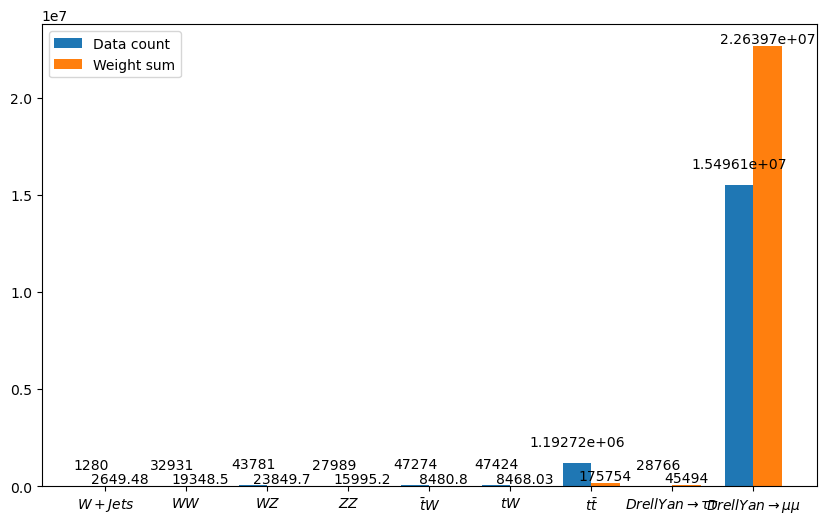

In [9]:
w_counts_full = np.zeros(bins.shape[0] - 1)
counts_full = np.zeros(bins.shape[0] - 1)
for j in range(17):
    print("Reading " + data_name + str(j))
    DF_whist = data_read_rescale(data_loc + data_name + str(j) + ".csv", limit=Process_limits, scale=Min_Max.T)
    w_counts, edges = np.histogram(DF_whist['Process'], weights=DF_whist['Weight'], bins=bins)
    counts, edges = np.histogram(DF_whist['Process'], bins=bins)
    w_counts_full = w_counts_full + w_counts
    counts_full = counts_full + counts
width = 0.35
plt.figure(figsize=[10, 6])
f_bars_1 = plt.bar(bins[:-1] - width/2 + 0.5, counts_full, width
                   #, log=True
                  )
f_bars_2 = plt.bar(bins[:-1] + width/2 + 0.5, w_counts_full, width
                   #, log=True
                  )
plt.xticks(range(len(legend_names)), legend_names)
plt.bar_label(f_bars_1
              , padding=10
             )
plt.bar_label(f_bars_2)
plt.legend(["Data count", "Weight sum"])

In [10]:
def model_fit(model_in, classes, data_loc, data_name, file_num, model_loc, model_name, min_max_scale, 
              class_weights_func, train_valid_split=0.7, epochs = 5): 
    model_checkpoint_callback_loss = tf.keras.callbacks.ModelCheckpoint(filepath=model_loc + model_name + "_loss",
                                                                       save_weights_only=True,
                                                                       monitor='val_loss',
                                                                       mode='min',
                                                                       save_best_only=True)
    model_checkpoint_callback_acc = tf.keras.callbacks.ModelCheckpoint(filepath=model_loc + model_name + "_acc",
                                                                       save_weights_only=True,
                                                                       monitor='val_accuracy',
                                                                       mode='max',
                                                                       save_best_only=True)
    model_checkpoint_callback_prec = tf.keras.callbacks.ModelCheckpoint(filepath=model_loc + model_name + "_prec",
                                                                       save_weights_only=True,
                                                                       monitor='val_precision',
                                                                       mode='max',
                                                                       save_best_only=True)
    train_hist_acc = np.array([])
    train_hist_loss = np.array([])
    valid_hist_acc = np.array([])
    valid_hist_loss = np.array([])
    Process_limits = [None, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    for j in range(file_num):
        print("Reading " + data_name + str(j))
        DF = data_read_rescale(data_loc + data_name + str(j) + ".csv", limit=Process_limits, scale=min_max_scale.T)
        DF = DF.sample(frac=1).reset_index(drop=True)
        Y = Y_rebuild(DF['Process'], classes)
        X = DF[DF.columns[2:]]
        split_num = int(X.shape[0]*train_valid_split)
        x_train = X.loc[:split_num-1]
        y_train = Y.loc[:split_num-1]
        x_valid = X.loc[split_num:]
        y_valid = Y.loc[split_num:]
        class_weights = class_weights_func(w_counts_full)
        weights = DF['Weight'].copy()
        for i in range(len(classes)):
            weights[DF['Process'] == i] *= class_weights[i]
        log = model_in.fit(x_train, y_train,
                        callbacks = [model_checkpoint_callback_loss, 
                                     model_checkpoint_callback_acc, 
                                     model_checkpoint_callback_prec],
                        batch_size = 150, 
                        epochs = epochs, 
                        verbose = 2,
                        sample_weight = weights[:split_num],
                        validation_data = (x_valid, y_valid, weights[split_num:]))
        train_hist_acc = np.append(train_hist_acc, log.history['accuracy'], axis=-1)
        train_hist_loss = np.append(train_hist_loss, log.history['loss'], axis=-1)
        valid_hist_acc = np.append(valid_hist_acc, log.history['val_accuracy'], axis=-1)
        valid_hist_loss = np.append(valid_hist_loss, log.history['val_loss'], axis=-1)
    model_in.save(model_loc + model_name + "_last")
    return model_in, train_hist_acc, train_hist_loss, valid_hist_acc, valid_hist_loss
data_loc = "/home/dominykas/dy_mas_do/MuMu/"
data_name = "MC_data_"

In [ ]:
model = Sequential(name="Classifier1")
model.add(Dense(X.shape[1], input_dim = X.shape[1], activation = ELU(1), name = 'ELU1'))
model.add(Dense(X.shape[1], activation = ELU(1), name = 'ELU2'))
model.add(Dense(X.shape[1], activation = ELU(1), name = 'ELU3'))
model.add(Dense(X.shape[1], activation = ELU(1), name = 'ELU4'))
model.add(Dense(X.shape[1], activation = ELU(1), name = 'ELU5'))
model.add(Dense(X.shape[1], activation = ELU(1), name = 'ELU6'))
#model.add(BatchNormalization())
model.add(Dense(len(legend_names), name = 'output'))
model.add(Softmax())
model.summary()

In [ ]:
model.compile(loss = CategoricalCrossentropy(), optimizer = Adam(), weighted_metrics = ['accuracy', Precision(name='precision')])

In [ ]:
def cwf(counts):
    counts[counts == 0] = min(counts[counts != 0])
    return np.sqrt(max(counts)/counts)*10

In [ ]:
model, train_hist_acc, train_hist_loss, valid_hist_acc, valid_hist_loss = model_fit(model, legend_names, 
                                                                                    data_loc, data_name, 16,
                                                                                    data_loc, "model", Min_Max, cwf)

In [11]:
def print_conf_matrix(y_true, y_pred, labels, ax, title, weights=None):
    if weights is None:
        weights = [np.full(len(y_true), 1.)]
    f_title = f'{title} (acc = {accuracy_score(y_true, y_pred, sample_weight=weights[0]):.3f})'
    if len(weights) == 2:
        f_title += f'(w_acc = {accuracy_score(y_true, y_pred, sample_weight=weights[1]):.3f})'
    disp = ConfusionMatrixDisplay(
        confusion_matrix = confusion_matrix(y_true, y_pred, sample_weight=weights[0], normalize='true', 
                                            labels=range(len(labels))), display_labels = labels)
    disp.plot(include_values = True, cmap = plt.cm.Blues, ax = ax)
    plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
    ax.set_title(f_title)
    ax.set_xlabel("Modelio spėjimas")
    ax.set_ylabel("Tikroji klasė", rotation='vertical')

In [ ]:
DF = data_read_rescale(data_loc + data_name + str(16) + ".csv", limit=Process_limits, scale=Min_Max.T)
#Y = Y_rebuild(DF['Process'], classes)
X = DF[DF.columns[2:]]
model = load_model(data_loc + "model_last")
figm, axsm = plt.subplots(1, 1, figsize=(7, 7))
#w_counts, edges = np.histogram(DF['Process'], weights=DF['Weight'], bins=bins)
#class_weights = cwf(w_counts)
#weights = DF['Weight'].copy()
#for i in range(len(legend_names)):
#    weights[DF['Process'] == i] *= class_weights[i]
print_conf_matrix(DF['Process'], np.argmax(model.predict(X), axis=-1), legend_names, axsm, 'Testavimo aibė')

In [ ]:
figm_loss, axsm_loss = plt.subplots(1, 1, figsize=(7, 7))
model.load_weights(data_loc + "model_loss")
print_conf_matrix(DF['Process'], np.argmax(model.predict(X), axis=-1), 
                  legend_names, axsm_loss, 'Testavimo aibė')
figm_loss.savefig(data_loc + "model_loss.pdf", bbox_inches="tight", pad_inches=0.15)

figm_acc, axsm_acc = plt.subplots(1, 1, figsize=(7, 7))
model.load_weights(data_loc + "model_acc")
print_conf_matrix(DF['Process'], np.argmax(model.predict(X), axis=-1), 
                  legend_names, axsm_acc, 'Testavimo aibė')
figm_acc.savefig(data_loc + "model_acc.pdf", bbox_inches="tight", pad_inches=0.15)

figm_prec, axsm_prec = plt.subplots(1, 1, figsize=(7, 7))
model.load_weights(data_loc + "model_prec")
print_conf_matrix(DF['Process'], np.argmax(model.predict(X), axis=-1), 
                  legend_names, axsm_prec, 'Testavimo aibė')
figm_prec.savefig(data_loc + "model_prec.pdf", bbox_inches="tight", pad_inches=0.15)

In [ ]:
fig, axs = plt.subplots(1, 2, dpi=200, figsize=(27/2.54, 10/2.54))
axs[0].set_xlabel("Mokymosi epochos")
axs[0].set_ylabel("Prarastis")
axs[1].set_xlabel("Mokymosi epochos")
axs[1].set_ylabel("Tisklumas")
xepochs = range(1, len(train_hist_loss) + 1)

axs[0].plot(xepochs, train_hist_loss, label = 'Mokymosi aibė')
axs[0].plot(xepochs, valid_hist_loss, label = 'Validacijos aibė')
#axs[0].title.set_text('Loss (CE)')
axs[0].legend()
#axs[0].show()

axs[1].plot(xepochs, train_hist_acc, label = 'Mokymosi aibė')
axs[1].plot(xepochs, valid_hist_acc, label = 'Validacijos aibė')
#axs[1].title.set_text('Metrics (Accuracy)')
axs[1].legend()
#axs[1].show()

#fig.savefig(r"/home/dominykas/Software/plot/model_epoch")

In [17]:
model_w1 = Sequential(name="Classifier1_w1")
model_w1.add(Dense(X.shape[1], input_dim = X.shape[1], activation = ELU(1), name = 'ELU1'))
model_w1.add(Dense(X.shape[1], activation = ELU(1), name = 'ELU2'))
model_w1.add(Dense(X.shape[1], activation = ELU(1), name = 'ELU3'))
model_w1.add(Dense(X.shape[1], activation = ELU(1), name = 'ELU4'))
model_w1.add(Dense(X.shape[1], activation = ELU(1), name = 'ELU5'))
model_w1.add(Dense(X.shape[1], activation = ELU(1), name = 'ELU6'))
#model.add(BatchNormalization())
model_w1.add(Dense(len(legend_names), name = 'output'))
model_w1.add(Softmax())
model_w1.compile(loss = CategoricalCrossentropy(), optimizer = Adam(), metrics = ['accuracy', Precision(name='precision')])
model_w1.summary()


Model: "Classifier1_w1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ELU1 (Dense)                 (None, 48)                2352      
_________________________________________________________________
ELU2 (Dense)                 (None, 48)                2352      
_________________________________________________________________
ELU3 (Dense)                 (None, 48)                2352      
_________________________________________________________________
ELU4 (Dense)                 (None, 48)                2352      
_________________________________________________________________
ELU5 (Dense)                 (None, 48)                2352      
_________________________________________________________________
ELU6 (Dense)                 (None, 48)                2352      
_________________________________________________________________
output (Dense)               (None, 9)              

In [19]:
def cwf_w1(counts):
    counts[counts == 0] = min(counts[counts != 0])
    return max(counts)/counts*1e-1
model_w1, train_hist_acc_w1, train_hist_loss_w1, valid_hist_acc_w1, valid_hist_loss_w1 = model_fit(
                                                                                    model_w1, legend_names, 
                                                                                    data_loc, data_name, 16,
                                                                                    data_loc, "model_w1", 
                                                                                    Min_Max, cwf_w1)

Reading MC_data_0
Epoch 1/5
4667/4667 - 7s - loss: 2.7900 - accuracy: 0.0017 - precision: 0.0000e+00 - val_loss: 3.2780 - val_accuracy: 0.0017 - val_precision: 0.0000e+00
Epoch 2/5
4667/4667 - 8s - loss: 2.7222 - accuracy: 0.0020 - precision: 0.0000e+00 - val_loss: 3.1229 - val_accuracy: 0.0017 - val_precision: 0.0000e+00
Epoch 3/5
4667/4667 - 8s - loss: 2.6340 - accuracy: 0.0153 - precision: 0.0000e+00 - val_loss: 2.9103 - val_accuracy: 0.0039 - val_precision: 0.0000e+00
Epoch 4/5
4667/4667 - 8s - loss: 2.5987 - accuracy: 0.0845 - precision: 0.0000e+00 - val_loss: 2.8788 - val_accuracy: 0.7978 - val_precision: 0.0000e+00
Epoch 5/5
4667/4667 - 7s - loss: 2.5892 - accuracy: 0.3457 - precision: 0.3684 - val_loss: 2.8901 - val_accuracy: 0.2858 - val_precision: 0.0000e+00
Reading MC_data_1
Epoch 1/5
4667/4667 - 8s - loss: 2.8018 - accuracy: 0.2779 - precision: 0.0000e+00 - val_loss: 2.4998 - val_accuracy: 0.1970 - val_precision: 0.0000e+00
Epoch 2/5
4667/4667 - 8s - loss: 2.8203 - accuracy

4667/4667 - 8s - loss: 2.5179 - accuracy: 0.4721 - precision: 0.1050 - val_loss: 2.6120 - val_accuracy: 0.0173 - val_precision: 0.8000
Reading MC_data_11
Epoch 1/5
4667/4667 - 7s - loss: 2.6143 - accuracy: 0.1206 - precision: 0.0026 - val_loss: 2.8867 - val_accuracy: 0.0367 - val_precision: 0.5000
Epoch 2/5
4667/4667 - 8s - loss: 3.5155 - accuracy: 0.1067 - precision: 0.0965 - val_loss: 2.8203 - val_accuracy: 0.0051 - val_precision: 0.0000e+00
Epoch 3/5
4667/4667 - 8s - loss: 2.6927 - accuracy: 0.1146 - precision: 0.0125 - val_loss: 3.9342 - val_accuracy: 0.0224 - val_precision: 0.0000e+00
Epoch 4/5
4667/4667 - 8s - loss: 2.7272 - accuracy: 0.1641 - precision: 0.5556 - val_loss: 2.9073 - val_accuracy: 0.0167 - val_precision: 0.4167
Epoch 5/5
4667/4667 - 8s - loss: 2.7194 - accuracy: 0.0987 - precision: 0.3896 - val_loss: 2.8131 - val_accuracy: 0.0142 - val_precision: 0.0000e+00
Reading MC_data_12
Epoch 1/5
4667/4667 - 6s - loss: 2.6161 - accuracy: 0.2450 - precision: 0.4167 - val_loss:

In [20]:
DF = pd.read_csv("/home/dominykas/dy_mas_do/MuMu/MC_data_" + str(16) + ".csv")
DF = DF.loc[DF['Process'] != 0]
DF['Process'] = DF['Process'] - 1
X = ((DF - Min_Max.T[0]) / (Min_Max.T[1] - Min_Max.T[0]))[DF.columns[2:]]
figm, axsm = plt.subplots(1, 1, figsize=(7, 7))
print_conf_matrix(DF['Process'], np.argmax(model_w1.predict(X), axis=-1), legend_names, axsm, 'Testavimo aibė')

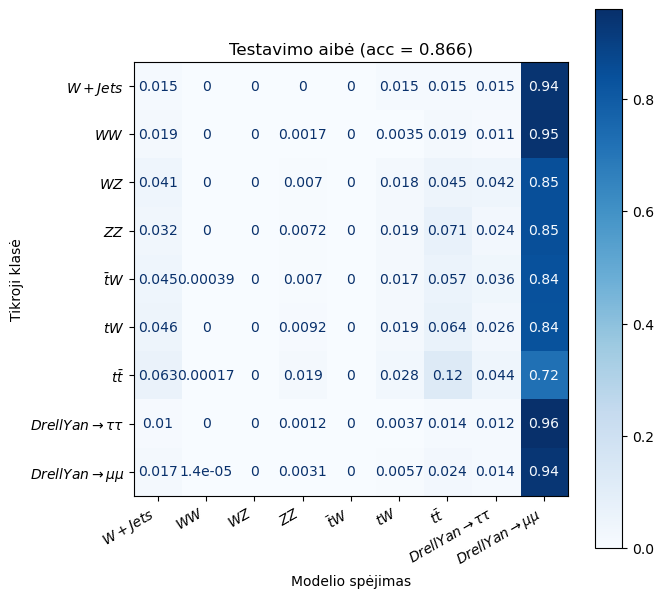

In [21]:
figm_loss, axsm_loss = plt.subplots(1, 1, figsize=(7, 7))
model_w1.load_weights(data_loc + "model_w1_loss")
print_conf_matrix(DF['Process'], np.argmax(model_w1.predict(X), axis=-1), 
                  legend_names, axsm_loss, 'Testavimo aibė')
figm_loss.savefig(data_loc + "model_w1_max_loss_old.pdf", bbox_inches="tight", pad_inches=0.15)

figm_acc, axsm_acc = plt.subplots(1, 1, figsize=(7, 7))
model_w1.load_weights(data_loc + "model_w1_acc")
print_conf_matrix(DF['Process'], np.argmax(model_w1.predict(X), axis=-1), 
                  legend_names, axsm_acc, 'Testavimo aibė')
figm_acc.savefig(data_loc + "model_w1_max_acc_old.pdf", bbox_inches="tight", pad_inches=0.15)

figm_prec, axsm_prec = plt.subplots(1, 1, figsize=(7, 7))
model_w1.load_weights(data_loc + "model_w1_prec")
print_conf_matrix(DF['Process'], np.argmax(model_w1.predict(X), axis=-1), 
                  legend_names, axsm_prec, 'Testavimo aibė')
figm_prec.savefig(data_loc + "model_w1_max_prec_old.pdf", bbox_inches="tight", pad_inches=0.15)

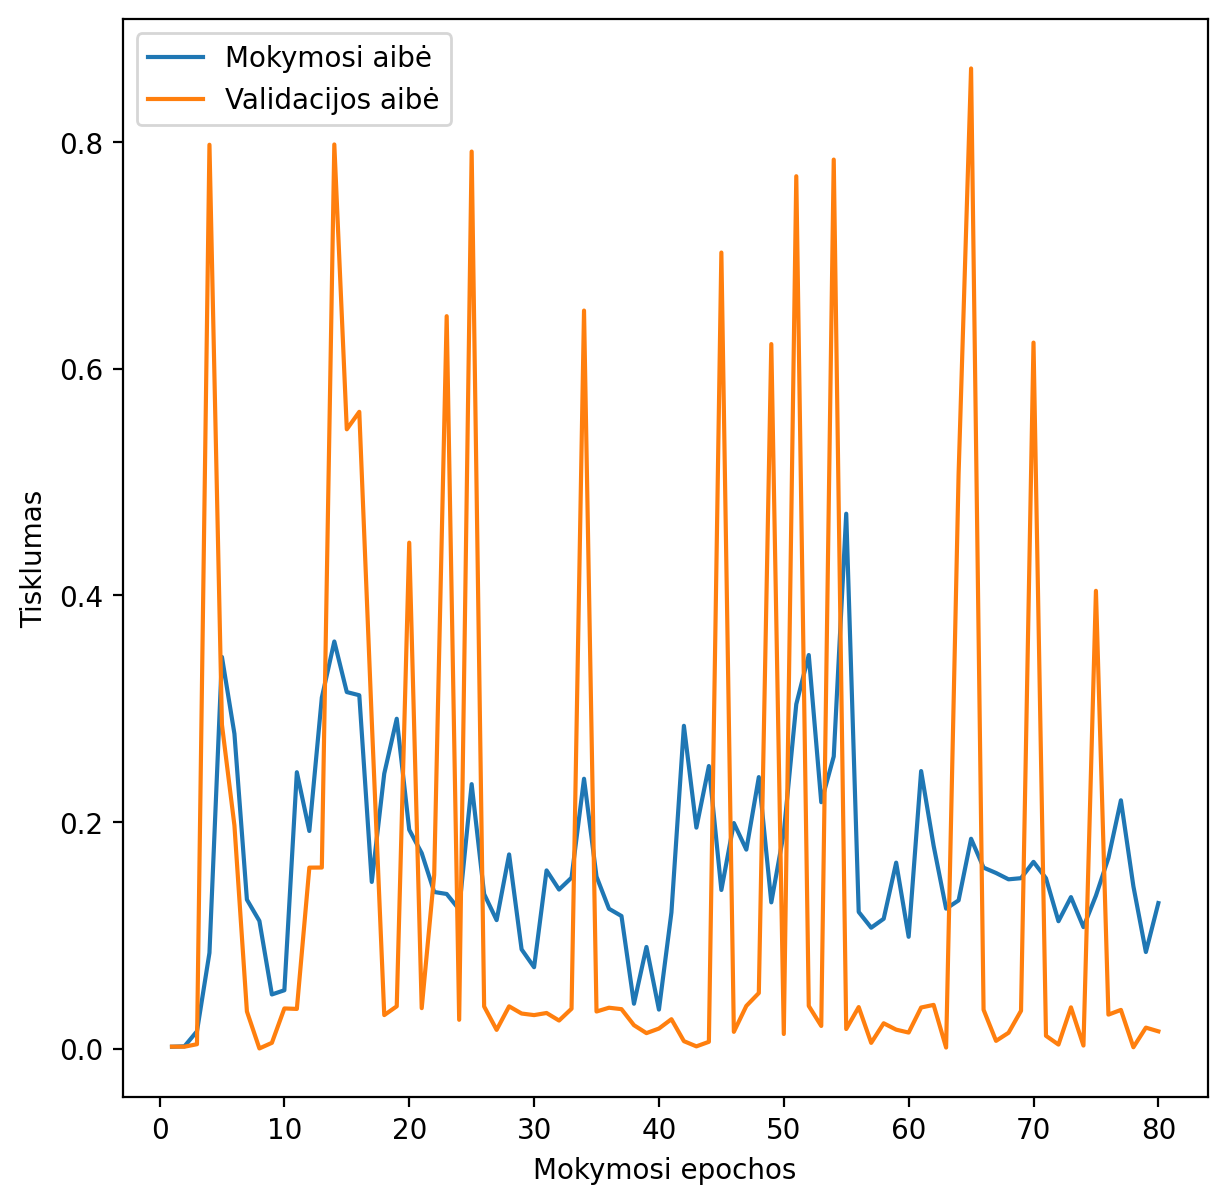

In [22]:
xepochs = range(1, len(train_hist_loss_w1) + 1)
fig_loss, axs_loss = plt.subplots(1, 1, dpi=200, figsize=(7, 7))
axs_loss.set_xlabel("Mokymosi epochos")
axs_loss.set_ylabel("Prarastis")
axs_loss.plot(xepochs, train_hist_loss_w1, label = 'Mokymosi aibė')
axs_loss.plot(xepochs, valid_hist_loss_w1, label = 'Validacijos aibė')
#axs[0].title.set_text('Loss (CE)')
axs_loss.legend()
#axs[0].show()
fig_loss.savefig(data_loc + "model_w1_loss_old.pdf")

fig_acc, axs_acc = plt.subplots(1, 1, dpi=200, figsize=(7, 7))
axs_acc.set_xlabel("Mokymosi epochos")
axs_acc.set_ylabel("Tisklumas")
axs_acc.plot(xepochs, train_hist_acc_w1, label = 'Mokymosi aibė')
axs_acc.plot(xepochs, valid_hist_acc_w1, label = 'Validacijos aibė')
#axs[1].title.set_text('Metrics (Accuracy)')
axs_acc.legend()
fig_acc.savefig(data_loc + "model_w1_acc_old.pdf")

In [ ]:
model_w2 = Sequential(name="Classifier1_w2")
model_w2.add(Dense(100, input_dim = X.shape[1], activation = ELU(1), name = 'ELU1'))
#model.add(ELU(1))
model_w2.add(Dense(100, activation = ELU(1), name = 'ELU2'))
#model.add(ELU(1))
model_w2.add(Dense(100, activation = ELU(1), name = 'ELU3'))
#model.add(ELU(1))
model_w2.add(Dense(100, activation = ELU(1), name = 'ELU4'))
#model.add(ELU(1))
#model.add(BatchNormalization())
model_w2.add(Dense(len(legend_names), name = 'output'))
model_w2.add(Softmax())
model_w2.compile(loss = CategoricalCrossentropy(), optimizer = Adam(), metrics = ['accuracy', Precision(name='precision')])
model_w2.summary()

In [ ]:
def cwf_w2(counts):
    counts[counts == 0] = min(counts[counts != 0])
    return max(counts[counts != max(counts)])/counts
model_w2, train_hist_acc_w2, train_hist_loss_w2, valid_hist_acc_w2, valid_hist_loss_w2 = model_fit(
                                                                                    model_w2, legend_names, 
                                                                                    data_loc, data_name, 16,
                                                                                    data_loc, "model_w2", 
                                                                                    Min_Max, cwf_w2)

In [ ]:
DF = pd.read_csv("/home/dominykas/dy_mas_do/MuMu/MC_data_" + str(i) + ".csv")
X = ((DF - Min_Max.T[0]) / (Min_Max.T[1] - Min_Max.T[0]))[DF.columns[2:]]
figm, axsm = plt.subplots(1, 1, figsize=(7, 7))
print_conf_matrix(DF['Process'], np.argmax(model_w2.predict(X), axis=-1), legend_names, axsm, 'Testavimo aibė')

In [ ]:
figm_loss, axsm_loss = plt.subplots(1, 1, figsize=(7, 7))
model_w2.load_weights(data_loc + "model_w2_loss")
print_conf_matrix(DF['Process'], np.argmax(model_w2.predict(X), axis=-1), 
                  legend_names, axsm_loss, 'Testavimo aibė')
figm_loss.savefig(data_loc + "model_w2_loss.pdf", bbox_inches="tight", pad_inches=0.15)

figm_acc, axsm_acc = plt.subplots(1, 1, figsize=(7, 7))
model_w2.load_weights(data_loc + "model_w2_acc")
print_conf_matrix(DF['Process'], np.argmax(model_w2.predict(X), axis=-1), 
                  legend_names, axsm_acc, 'Testavimo aibė')
figm_acc.savefig(data_loc + "model_w2_acc.pdf", bbox_inches="tight", pad_inches=0.15)

figm_prec, axsm_prec = plt.subplots(1, 1, figsize=(7, 7))
model_w2.load_weights(data_loc + "model_w2_prec")
print_conf_matrix(DF['Process'], np.argmax(model_w2.predict(X), axis=-1), 
                  legend_names, axsm_prec, 'Testavimo aibė')
figm_prec.savefig(data_loc + "model_w2_prec.pdf", bbox_inches="tight", pad_inches=0.15)


In [ ]:
fig, axs = plt.subplots(1, 2, dpi=200, figsize=(27/2.54, 10/2.54))
axs[0].set_xlabel("Mokymosi epochos")
axs[0].set_ylabel("Prarastis")
axs[1].set_xlabel("Mokymosi epochos")
axs[1].set_ylabel("Tisklumas")
xepochs = range(1, len(train_hist_loss_w2) + 1)

axs[0].plot(xepochs, train_hist_loss_w2, label = 'Mokymosi aibė')
axs[0].plot(xepochs, valid_hist_loss_w2, label = 'Validacijos aibė')
#axs[0].title.set_text('Loss (CE)')
axs[0].legend()
#axs[0].show()

axs[1].plot(xepochs, train_hist_acc_w2, label = 'Mokymosi aibė')
axs[1].plot(xepochs, valid_hist_acc_w2, label = 'Validacijos aibė')
#axs[1].title.set_text('Metrics (Accuracy)')
axs[1].legend()

In [ ]:
legend_names_mod = ["$QCD$ and $W + Jets$", "$W-Z$", "$tW-\\bar{t}W$", "$t\\bar{t}$", 
                    "$Drell Yan \\rightarrow \\tau\\tau$", "$Drell Yan \\rightarrow \\mu\\mu$"]

In [ ]:
model_l1 = Sequential(name="Classifier1_l1")
model_l1.add(Dense(100, input_dim = X.shape[1], activation = ELU(1), name = 'ELU1'))
#model.add(ELU(1))
model_l1.add(Dense(100, activation = ELU(1), name = 'ELU2'))
#model.add(ELU(1))
model_l1.add(Dense(100, activation = ELU(1), name = 'ELU3'))
#model.add(ELU(1))
model_l1.add(Dense(100, activation = ELU(1), name = 'ELU4'))
#model.add(ELU(1))
#model.add(BatchNormalization())
model_l1.add(Dense(len(legend_names_mod), name = 'output'))
model_l1.add(Softmax())
model_l1.compile(loss = CategoricalCrossentropy(), optimizer = Adam(), metrics = ['accuracy', Precision(name='precision')])
model_l1.summary()

In [ ]:
def model_fit_l1(model_in, classes, data_loc, data_name, file_num, model_loc, model_name, min_max_scale, 
              class_weights_func, class_recomb, train_valid_split=0.7, epochs = 5): 
    plt.figure(figsize=[10, 6])
    model_checkpoint_callback_loss = tf.keras.callbacks.ModelCheckpoint(filepath=model_loc + model_name + "_loss",
                                                                       save_weights_only=True,
                                                                       monitor='val_loss',
                                                                       mode='min',
                                                                       save_best_only=True)
    model_checkpoint_callback_acc = tf.keras.callbacks.ModelCheckpoint(filepath=model_loc + model_name + "_acc",
                                                                       save_weights_only=True,
                                                                       monitor='val_accuracy',
                                                                       mode='max',
                                                                       save_best_only=True)
    model_checkpoint_callback_prec = tf.keras.callbacks.ModelCheckpoint(filepath=model_loc + model_name + "_prec",
                                                                       save_weights_only=True,
                                                                       monitor='val_precision',
                                                                       mode='max',
                                                                       save_best_only=True)
    train_hist_acc = np.array([])
    train_hist_loss = np.array([])
    valid_hist_acc = np.array([])
    valid_hist_loss = np.array([])
    bins = np.linspace(-0.5, len(legend_names) - 0.5, len(legend_names)+1)
    w_counts_full = np.zeros(len(classes))
    counts_full = np.zeros(len(classes))
    for j in range(file_num):
        DF = pd.read_csv(data_loc + data_name + str(j) + ".csv")
        print("Reading " + data_name + str(j))
        Y_temp = np.full([DF.shape[0], len(class_recomb)], False)
        Y = pd.DataFrame(Y_temp, columns=classes)
        for i in range(len(class_recomb)):
            for k in range(len(class_recomb[i])):
                Y[classes[i]] = (Y[classes[i]] | (DF['Process'] == class_recomb[i][k]))*1
        #print(Y.dtypes)
        X = ((DF - min_max_scale.T[0]) / (min_max_scale.T[1] - min_max_scale.T[0]))[DF.columns[2:]]

        #x_train, x_valid, y_train, y_valid = train_test_split(X, Ys_all, test_size = 0.3)
        split_num = int(X.shape[0]*train_valid_split)
        x_train = X.loc[:split_num-1]
        y_train = Y.loc[:split_num-1]
        x_valid = X.loc[split_num:]
        y_valid = Y.loc[split_num:]
        print(x_train.shape, split_num)
        w_counts, edges = np.histogram(DF['Process'], weights=DF['Weight'], bins=bins)
        for i in range(len(class_recomb)):
            for k in range(len(class_recomb[i])):
                w_counts_full[i] = w_counts_full[i] + w_counts[class_recomb[i][k]]
        counts, edges = np.histogram(DF['Process'], bins=bins)
        for i in range(len(class_recomb)):
            for k in range(len(class_recomb[i])):
                counts_full[i] = counts_full[i] + counts[class_recomb[i][k]]
        class_weights = class_weights_func(w_counts)
        #counts[counts == 0] = min(counts[counts != 0])
        #class_weights = np.sqrt(max(counts)/counts)
        #class_weights_fin = {j: class_weights[j] for j in range(len(classes))}
        weights = DF['Weight'].copy()
        for i in range(len(class_recomb)):
            for k in range(len(class_recomb[i])):
                weights[DF['Process'] == class_recomb[i][k]] *= class_weights[i]
        log = model_in.fit(x_train, y_train,
                        callbacks = [model_checkpoint_callback_loss, 
                                     model_checkpoint_callback_acc, 
                                     model_checkpoint_callback_prec],
                        batch_size = 150, 
                        epochs = epochs, 
                        verbose = 2,
                        #class_weight=class_weights_fin,
                        sample_weight = weights[:split_num],
                        validation_data = (x_valid, y_valid, weights[split_num:]))
        train_hist_acc = np.append(train_hist_acc, log.history['accuracy'], axis=-1)
        train_hist_loss = np.append(train_hist_loss, log.history['loss'], axis=-1)
        valid_hist_acc = np.append(valid_hist_acc, log.history['val_accuracy'], axis=-1)
        valid_hist_loss = np.append(valid_hist_loss, log.history['val_loss'], axis=-1)
        #print(train_hist_acc.shape)
        #plt.plot(log.history['accuracy'])
    model_in.save(model_loc + model_name + "_last")
    width = 0.35
    bins = np.linspace(-0.5, len(classes) - 0.5, len(classes)+1)
    f_bars_1 = plt.bar(bins[:-1] - width/2 + 0.5, counts_full, width)
    f_bars_2 = plt.bar(bins[:-1] + width/2 + 0.5, w_counts_full, width)
    plt.xticks(range(len(classes)), classes)
    plt.bar_label(f_bars_1, padding=10)
    plt.bar_label(f_bars_2)
    plt.legend(["Data count", "Weight sum"])
    #plt.legend(range(len(classes)))
    return model_in, train_hist_acc, train_hist_loss, valid_hist_acc, valid_hist_loss
class_recomb_l1 = [[0, 1], [2, 3, 4], [5, 6], [7], [8], [9]]

In [ ]:
def cwf_l1(counts):
    res = np.zeros(6)
    res[0] = counts[0] + counts[1]
    res[1] = counts[2] + counts[3] + counts[4]
    res[2] = counts[5] + counts[6]
    res[3] = counts[7]
    res[4] = counts[8]
    res[5] = counts[9]
    res[res == 0] = min(res[res != 0])
    return max(res)/res
class_recomb_l1 = [[0, 1], [2, 3, 4], [5, 6], [7], [8], [9]]
model_l1, train_hist_acc_l1, train_hist_loss_l1, valid_hist_acc_l1, valid_hist_loss_l1 = model_fit_l1(
                                                                                    model_l1, legend_names_mod, 
                                                                                    data_loc, data_name, 16,
                                                                                    data_loc, "model_l1", 
                                                                                    Min_Max, cwf_l1, class_recomb_l1)

In [ ]:
DF = pd.read_csv("/home/dominykas/dy_mas_do/MuMu/MC_data_" + str(i) + ".csv")
X = ((DF - Min_Max.T[0]) / (Min_Max.T[1] - Min_Max.T[0]))[DF.columns[2:]]
figm, axsm = plt.subplots(1, 1, figsize=(7, 7))
Y_temp = DF['Process'].copy()
for i in range(len(class_recomb_l1)):
    for k in range(len(class_recomb_l1[i])):
        Y_temp[DF['Process'] == class_recomb_l1[i][k]] = i
print_conf_matrix(DF['Process'], np.argmax(model_l1.predict(X), axis=-1), legend_names_mod, axsm, 'Testavimo aibė')

In [ ]:
figm_loss, axsm_loss = plt.subplots(1, 1, figsize=(7, 7))
model_l1.load_weights(data_loc + "model_l1_loss")
print_conf_matrix(Y_temp, np.argmax(model_l1.predict(X), axis=-1), legend_names_mod, axsm_loss, 'Testavimo aibė')
figm_loss.savefig(data_loc + "model_l1_loss.pdf", bbox_inches="tight", pad_inches=0.15)

figm_acc, axsm_acc = plt.subplots(1, 1, figsize=(7, 7))
model_l1.load_weights(data_loc + "model_l1_acc")
print_conf_matrix(Y_temp, np.argmax(model_l1.predict(X), axis=-1), legend_names_mod, axsm_acc, 'Testavimo aibė')
figm_acc.savefig(data_loc + "model_l1_acc.pdf", bbox_inches="tight", pad_inches=0.15)

figm_prec, axsm_prec = plt.subplots(1, 1, figsize=(7, 7))
model_l1.load_weights(data_loc + "model_l1_prec")
print_conf_matrix(Y_temp, np.argmax(model_l1.predict(X), axis=-1), legend_names_mod, axsm_prec, 'Testavimo aibė')
figm_prec.savefig(data_loc + "model_l1_prec.pdf", bbox_inches="tight", pad_inches=0.15)

In [ ]:
fig, axs = plt.subplots(1, 2, dpi=200, figsize=(27/2.54, 10/2.54))
axs[0].set_xlabel("Mokymosi epochos")
axs[0].set_ylabel("Prarastis")
axs[1].set_xlabel("Mokymosi epochos")
axs[1].set_ylabel("Tisklumas")
xepochs = range(1, len(train_hist_loss_l1) + 1)

axs[0].plot(xepochs, train_hist_loss_l1, label = 'Mokymosi aibė')
axs[0].plot(xepochs, valid_hist_loss_l1, label = 'Validacijos aibė')
#axs[0].title.set_text('Loss (CE)')
axs[0].legend()
#axs[0].show()

axs[1].plot(xepochs, train_hist_acc_l1, label = 'Mokymosi aibė')
axs[1].plot(xepochs, valid_hist_acc_l1, label = 'Validacijos aibė')
#axs[1].title.set_text('Metrics (Accuracy)')
axs[1].legend()